In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterio.mask import mask
from scipy import stats
from rasterio.windows import from_bounds
from matplotlib.colors import ListedColormap

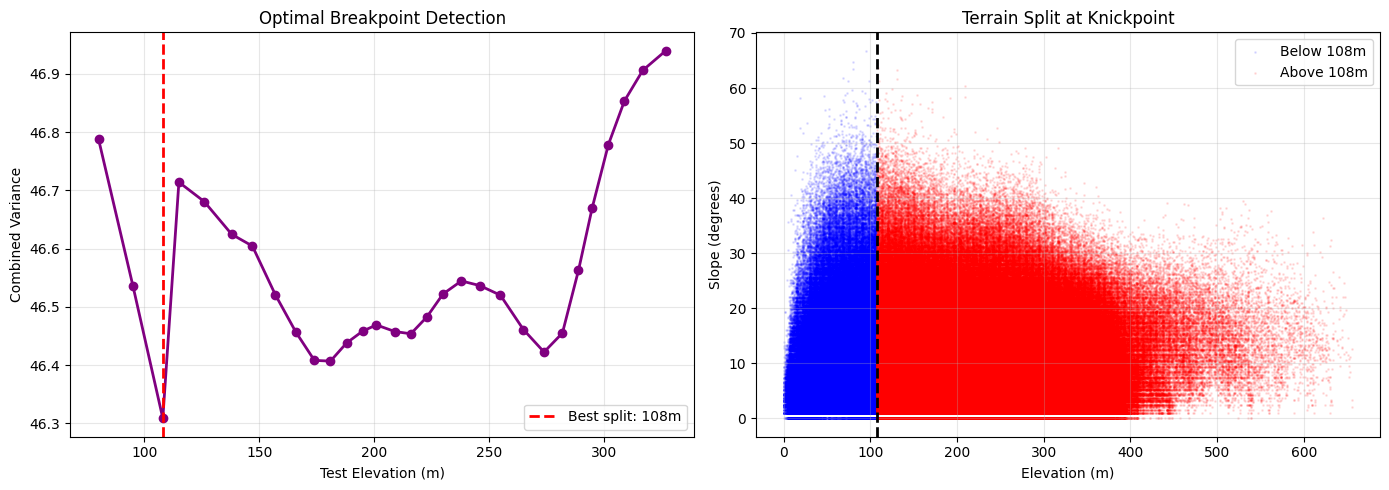


=== KNICKPOINT AT ~108m ===

BELOW knickpoint (108m):
  Mean slope: 10.37°
  Median slope: 8.57°
  Std dev: 7.90°

ABOVE knickpoint (108m):
  Mean slope: 8.12°
  Median slope: 6.35°
  Std dev: 6.59°

Difference in mean slope: 2.25°


In [6]:
# Statistical anaylsis 
# Your area coordinates
min_x, min_y = 222103, 6208992
max_x, max_y = 275034, 6253454

# Open DEM
with rasterio.open('/Users/Glong1/Desktop/Andes/Andes_watersheds/RapelRiver/rapel_SRTMGL130m_dem_utm.tif') as dem:
    window = from_bounds(min_x, min_y, max_x, max_y, dem.transform)
    elevation = dem.read(1, window=window)
    transform = dem.window_transform(window)
    nodata = dem.nodata

# Calculate slope
cell_size = transform[0]
dy, dx = np.gradient(elevation, cell_size)
slope_degrees = np.degrees(np.arctan(np.sqrt(dx**2 + dy**2)))

# Filter valid values
valid_mask = (~np.isnan(slope_degrees) & ~np.isnan(elevation) & 
              (elevation > 0) & (elevation < 10000))
if nodata is not None:
    valid_mask = valid_mask & (elevation != nodata)

slope_valid = slope_degrees[valid_mask]
elevation_valid = elevation[valid_mask]

# Split data into elevation bins and test different breakpoints
test_elevations = np.percentile(elevation_valid, np.linspace(10, 90, 30))
variances = []

for test_elev in test_elevations:
    # Split into above and below
    below = slope_valid[elevation_valid < test_elev]
    above = slope_valid[elevation_valid >= test_elev]
    
    if len(below) > 100 and len(above) > 100:
        # Calculate combined variance (lower = better split)
        total_var = (np.var(below) * len(below) + np.var(above) * len(above)) / len(slope_valid)
        variances.append(total_var)
    else:
        variances.append(np.nan)

# Find elevation with minimum variance (best natural split)
best_idx = np.nanargmin(variances)
knickpoint_elev = test_elevations[best_idx]

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Variance by breakpoint elevation
ax1.plot(test_elevations, variances, linewidth=2, color='purple', marker='o')
ax1.axvline(knickpoint_elev, color='red', linestyle='--', linewidth=2, 
            label=f'Best split: {knickpoint_elev:.0f}m')
ax1.set_xlabel('Test Elevation (m)')
ax1.set_ylabel('Combined Variance')
ax1.set_title('Optimal Breakpoint Detection')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Show the split
ax2.scatter(elevation_valid[elevation_valid < knickpoint_elev], 
            slope_valid[elevation_valid < knickpoint_elev],
            alpha=0.1, s=1, c='blue', label=f'Below {knickpoint_elev:.0f}m')
ax2.scatter(elevation_valid[elevation_valid >= knickpoint_elev], 
            slope_valid[elevation_valid >= knickpoint_elev],
            alpha=0.1, s=1, c='red', label=f'Above {knickpoint_elev:.0f}m')
ax2.axvline(knickpoint_elev, color='black', linestyle='--', linewidth=2)
ax2.set_xlabel('Elevation (m)')
ax2.set_ylabel('Slope (degrees)')
ax2.set_title('Terrain Split at Knickpoint')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Compare statistics above and below
below_slopes = slope_valid[elevation_valid < knickpoint_elev]
above_slopes = slope_valid[elevation_valid >= knickpoint_elev]

print(f"\n=== KNICKPOINT AT ~{knickpoint_elev:.0f}m ===")
print(f"\nBELOW knickpoint ({knickpoint_elev:.0f}m):")
print(f"  Mean slope: {np.mean(below_slopes):.2f}°")
print(f"  Median slope: {np.median(below_slopes):.2f}°")
print(f"  Std dev: {np.std(below_slopes):.2f}°")

print(f"\nABOVE knickpoint ({knickpoint_elev:.0f}m):")
print(f"  Mean slope: {np.mean(above_slopes):.2f}°")
print(f"  Median slope: {np.median(above_slopes):.2f}°")
print(f"  Std dev: {np.std(above_slopes):.2f}°")

print(f"\nDifference in mean slope: {abs(np.mean(below_slopes) - np.mean(above_slopes)):.2f}°")

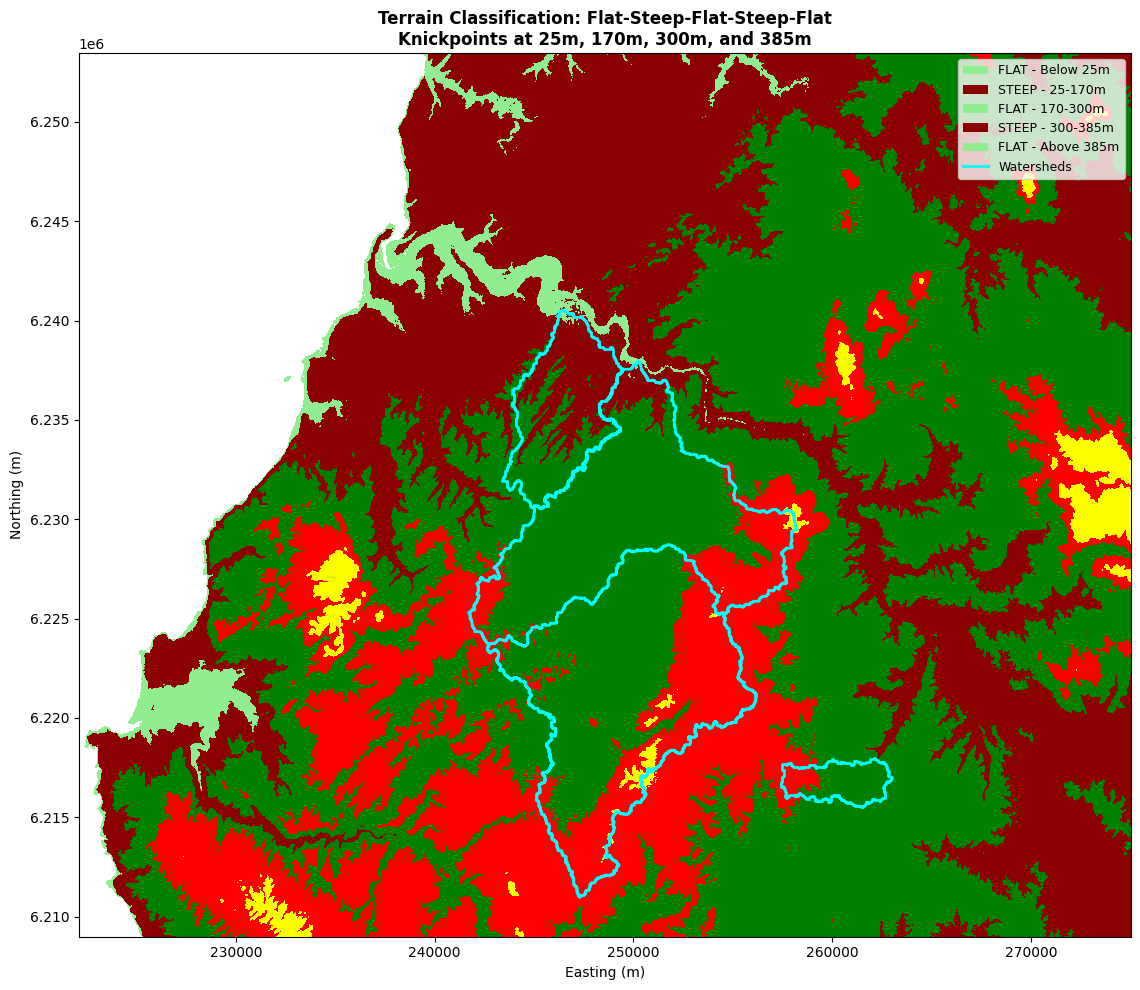


=== TERRAIN CLASSIFICATION STATISTICS ===
Knickpoint elevations: 25m, 170m, 300m, and 385m

FLAT - Low elevation (<25m):
  Pixels: 70,547 (2.7%)
  Area: ~52.77 km²

STEEP - Canyon zone (25-170m):
  Pixels: 805,637 (30.6%)
  Area: ~602.66 km²

FLAT - Mid elevation (170-300m):
  Pixels: 1,251,885 (47.5%)
  Area: ~936.48 km²

STEEP - High elevation (300-385m):
  Pixels: 466,506 (17.7%)
  Area: ~348.97 km²

FLAT - Top elevation (>385m):
  Pixels: 39,940 (1.5%)
  Area: ~29.88 km²

=== SUMMARY ===
Total FLAT areas: 1,362,372 pixels (51.7%) = ~1019.13 km²
Total STEEP areas: 1,272,143 pixels (48.3%) = ~951.63 km²


In [8]:
# Your area coordinates
min_x, min_y = 222103, 6208992
max_x, max_y = 275034, 6253454

# Knickpoint elevations - now with 4 knickpoints creating 5 zones
knickpoint_low = 25      # meters
knickpoint_mid = 170     # meters
knickpoint_high = 300    # meters
knickpoint_top = 385     # meters - NEW!

# Open DEM and extract subset
with rasterio.open('/Users/Glong1/Desktop/Andes/Andes_watersheds/RapelRiver/rapel_SRTMGL130m_dem_utm.tif') as dem:
    window = from_bounds(min_x, min_y, max_x, max_y, dem.transform)
    elevation = dem.read(1, window=window)
    transform = dem.window_transform(window)
    nodata = dem.nodata
    
    # Get the bounds of the cropped window for plotting
    window_bounds = rasterio.windows.bounds(window, dem.transform)

# Read shapefiles
shp1 = gpd.read_file('/Users/Glong1/Desktop/Andes/AndesTG/Rapel/output_polygons/RP_S2_mask/RP_S2_mask.shp')
shp2 = gpd.read_file('/Users/Glong1/Desktop/Andes/AndesTG/Rapel/output_polygons/RP_S3_mask/RP_S3_mask.shp')
shp3 = gpd.read_file('/Users/Glong1/Desktop/Andes/AndesTG/Rapel/output_polygons/RP_S3u_mask/RP_S3u_mask.shp')
shp4 = gpd.read_file('/Users/Glong1/Desktop/Andes/AndesTG/Rapel/output_polygons/RP_S4u_mask/RP_S4u_mask.shp')

# Calculate slope
cell_size = transform[0]
dy, dx = np.gradient(elevation, cell_size)
slope_degrees = np.degrees(np.arctan(np.sqrt(dx**2 + dy**2)))

# Create classification with 5 zones alternating FLAT-STEEP-FLAT-STEEP-FLAT
terrain_class = np.zeros_like(elevation)
terrain_class[(elevation > 0) & (elevation < knickpoint_low)] = 1      # FLAT - Low
terrain_class[(elevation >= knickpoint_low) & (elevation < knickpoint_mid)] = 2  # STEEP - Canyon
terrain_class[(elevation >= knickpoint_mid) & (elevation < knickpoint_high)] = 3  # FLAT - Mid
terrain_class[(elevation >= knickpoint_high) & (elevation < knickpoint_top)] = 4  # STEEP - High
terrain_class[(elevation >= knickpoint_top) & (elevation < 10000)] = 5  # FLAT - Top

# Mask out nodata
if nodata is not None:
    terrain_class[elevation == nodata] = 0
terrain_class[np.isnan(elevation)] = 0
terrain_class[elevation <= 0] = 0

# Create the map
fig, ax = plt.subplots(figsize=(12, 10))

# Colors alternating: white (nodata), green (flat), red (steep), green (flat), red (steep), green (flat)
colors = ['white', 'lightgreen', 'darkred', 'green', 'red', 'yellow']
cmap = ListedColormap(colors)
im = ax.imshow(terrain_class, cmap=cmap, vmin=0, vmax=5, 
               extent=[window_bounds[0], window_bounds[2], window_bounds[1], window_bounds[3]])

# Plot shapefile outlines
shp1.boundary.plot(ax=ax, color='cyan', linewidth=2)
shp2.boundary.plot(ax=ax, color='cyan', linewidth=2)
shp3.boundary.plot(ax=ax, color='cyan', linewidth=2)
shp4.boundary.plot(ax=ax, color='cyan', linewidth=2)

ax.set_title(f'Terrain Classification: Flat-Steep-Flat-Steep-Flat\nKnickpoints at {knickpoint_low}m, {knickpoint_mid}m, {knickpoint_high}m, and {knickpoint_top}m', 
             fontsize=12, fontweight='bold')
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')

# Create custom legend
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [
    Patch(facecolor='lightgreen', label=f'FLAT - Below {knickpoint_low}m'),
    Patch(facecolor='darkred', label=f'STEEP - {knickpoint_low}-{knickpoint_mid}m'),
    Patch(facecolor='lightgreen', label=f'FLAT - {knickpoint_mid}-{knickpoint_high}m'),
    Patch(facecolor='darkred', label=f'STEEP - {knickpoint_high}-{knickpoint_top}m'),
    Patch(facecolor='lightgreen', label=f'FLAT - Above {knickpoint_top}m'),
    Line2D([0], [0], color='cyan', linewidth=2, label='Watersheds')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=9)

plt.tight_layout()
plt.show()

# Print statistics
flat_low = np.sum(terrain_class == 1)
steep_canyon = np.sum(terrain_class == 2)
flat_mid = np.sum(terrain_class == 3)
steep_high = np.sum(terrain_class == 4)
flat_top = np.sum(terrain_class == 5)
total_valid = flat_low + steep_canyon + flat_mid + steep_high + flat_top

print(f"\n=== TERRAIN CLASSIFICATION STATISTICS ===")
print(f"Knickpoint elevations: {knickpoint_low}m, {knickpoint_mid}m, {knickpoint_high}m, and {knickpoint_top}m")
print(f"\nFLAT - Low elevation (<{knickpoint_low}m):")
print(f"  Pixels: {flat_low:,} ({flat_low/total_valid*100:.1f}%)")
print(f"  Area: ~{flat_low * cell_size**2 / 1e6:.2f} km²")

print(f"\nSTEEP - Canyon zone ({knickpoint_low}-{knickpoint_mid}m):")
print(f"  Pixels: {steep_canyon:,} ({steep_canyon/total_valid*100:.1f}%)")
print(f"  Area: ~{steep_canyon * cell_size**2 / 1e6:.2f} km²")

print(f"\nFLAT - Mid elevation ({knickpoint_mid}-{knickpoint_high}m):")
print(f"  Pixels: {flat_mid:,} ({flat_mid/total_valid*100:.1f}%)")
print(f"  Area: ~{flat_mid * cell_size**2 / 1e6:.2f} km²")

print(f"\nSTEEP - High elevation ({knickpoint_high}-{knickpoint_top}m):")
print(f"  Pixels: {steep_high:,} ({steep_high/total_valid*100:.1f}%)")
print(f"  Area: ~{steep_high * cell_size**2 / 1e6:.2f} km²")

print(f"\nFLAT - Top elevation (>{knickpoint_top}m):")
print(f"  Pixels: {flat_top:,} ({flat_top/total_valid*100:.1f}%)")
print(f"  Area: ~{flat_top * cell_size**2 / 1e6:.2f} km²")

# Summary by terrain type
total_flat = flat_low + flat_mid + flat_top
total_steep = steep_canyon + steep_high
print(f"\n=== SUMMARY ===")
print(f"Total FLAT areas: {total_flat:,} pixels ({total_flat/total_valid*100:.1f}%) = ~{total_flat * cell_size**2 / 1e6:.2f} km²")
print(f"Total STEEP areas: {total_steep:,} pixels ({total_steep/total_valid*100:.1f}%) = ~{total_steep * cell_size**2 / 1e6:.2f} km²")

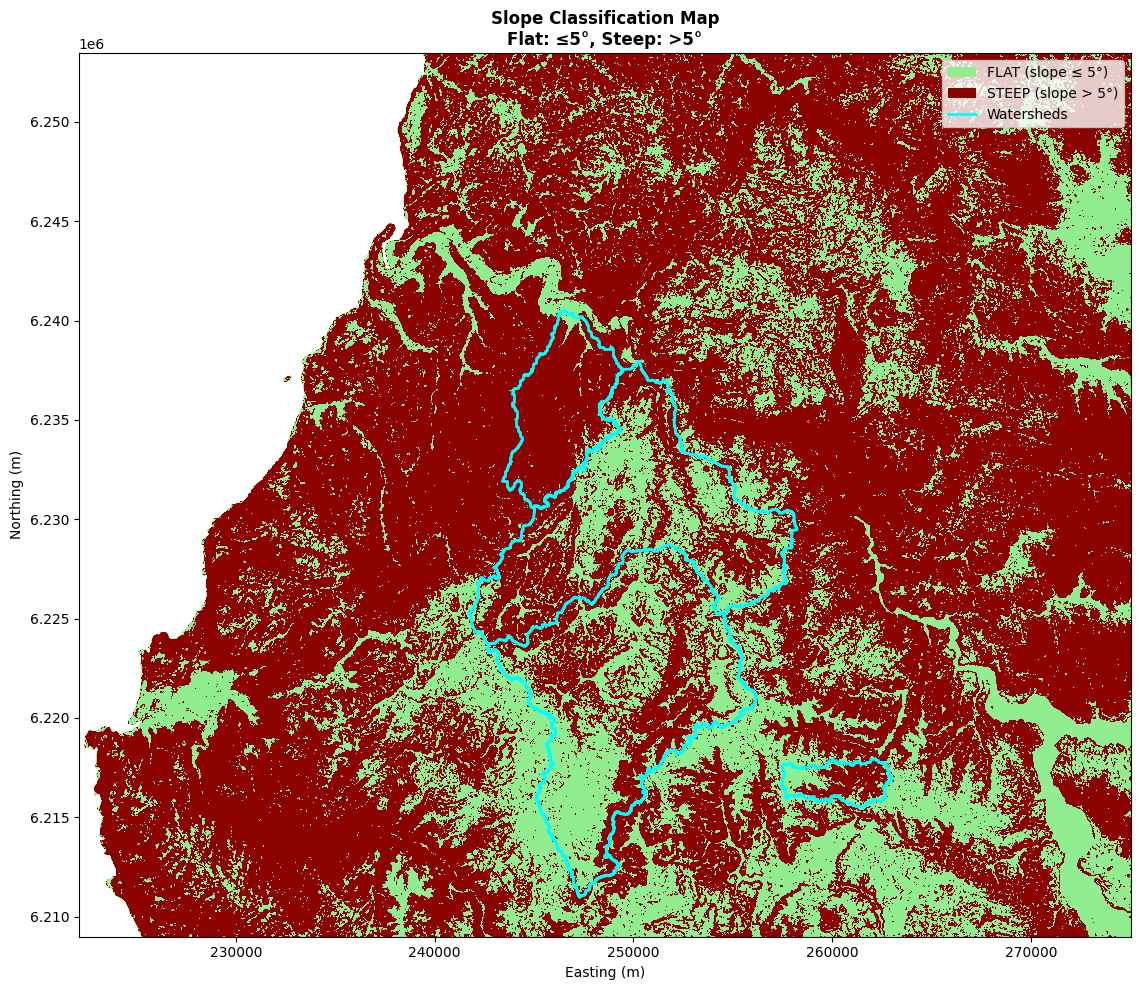


=== SLOPE CLASSIFICATION STATISTICS ===
Slope threshold: 5°

FLAT areas (slope ≤ 5°):
  Pixels: 1,012,529 (38.4%)
  Area: ~757.43 km²
  Mean slope: 2.64°

STEEP areas (slope > 5°):
  Pixels: 1,621,986 (61.6%)
  Area: ~1213.33 km²
  Mean slope: 12.09°

Overall slope statistics:
  Mean: 8.46°
  Max: 66.78°
  Min: 0.00°


In [9]:
# Your area coordinates
min_x, min_y = 222103, 6208992
max_x, max_y = 275034, 6253454

# Slope threshold in degrees - adjust this to your preference
slope_threshold = 5  # degrees (slopes > 5° are "steep", <= 5° are "flat")

# Open DEM and extract subset
with rasterio.open('/Users/Glong1/Desktop/Andes/Andes_watersheds/RapelRiver/rapel_SRTMGL130m_dem_utm.tif') as dem:
    window = from_bounds(min_x, min_y, max_x, max_y, dem.transform)
    elevation = dem.read(1, window=window)
    transform = dem.window_transform(window)
    nodata = dem.nodata
    
    # Get the bounds of the cropped window for plotting
    window_bounds = rasterio.windows.bounds(window, dem.transform)

# Read shapefiles
shp1 = gpd.read_file('/Users/Glong1/Desktop/Andes/AndesTG/Rapel/output_polygons/RP_S2_mask/RP_S2_mask.shp')
shp2 = gpd.read_file('/Users/Glong1/Desktop/Andes/AndesTG/Rapel/output_polygons/RP_S3_mask/RP_S3_mask.shp')
shp3 = gpd.read_file('/Users/Glong1/Desktop/Andes/AndesTG/Rapel/output_polygons/RP_S3u_mask/RP_S3u_mask.shp')
shp4 = gpd.read_file('/Users/Glong1/Desktop/Andes/AndesTG/Rapel/output_polygons/RP_S4u_mask/RP_S4u_mask.shp')

# Calculate slope using gradient
cell_size = transform[0]  # Get pixel size in meters
dy, dx = np.gradient(elevation, cell_size)  # Calculate elevation change
slope_degrees = np.degrees(np.arctan(np.sqrt(dx**2 + dy**2)))  # Convert to degrees

# Create slope classification: 0=nodata, 1=flat, 2=steep
slope_class = np.zeros_like(elevation)
slope_class[(elevation > 0) & (slope_degrees <= slope_threshold)] = 1  # FLAT
slope_class[(elevation > 0) & (slope_degrees > slope_threshold)] = 2   # STEEP

# Mask out nodata
if nodata is not None:
    slope_class[elevation == nodata] = 0
slope_class[np.isnan(elevation)] = 0
slope_class[elevation <= 0] = 0

# Create the map
fig, ax = plt.subplots(figsize=(12, 10))

# Define colors: white for nodata, green for flat, red for steep
colors = ['white', 'lightgreen', 'darkred']
cmap = ListedColormap(colors)
im = ax.imshow(slope_class, cmap=cmap, vmin=0, vmax=2, 
               extent=[window_bounds[0], window_bounds[2], window_bounds[1], window_bounds[3]])

# Plot shapefile outlines
shp1.boundary.plot(ax=ax, color='cyan', linewidth=2)
shp2.boundary.plot(ax=ax, color='cyan', linewidth=2)
shp3.boundary.plot(ax=ax, color='cyan', linewidth=2)
shp4.boundary.plot(ax=ax, color='cyan', linewidth=2)

ax.set_title(f'Slope Classification Map\nFlat: ≤{slope_threshold}°, Steep: >{slope_threshold}°', 
             fontsize=12, fontweight='bold')
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')

# Create custom legend
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [
    Patch(facecolor='lightgreen', label=f'FLAT (slope ≤ {slope_threshold}°)'),
    Patch(facecolor='darkred', label=f'STEEP (slope > {slope_threshold}°)'),
    Line2D([0], [0], color='cyan', linewidth=2, label='Watersheds')
]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

# Print statistics
flat_pixels = np.sum(slope_class == 1)
steep_pixels = np.sum(slope_class == 2)
total_valid = flat_pixels + steep_pixels

print(f"\n=== SLOPE CLASSIFICATION STATISTICS ===")
print(f"Slope threshold: {slope_threshold}°")
print(f"\nFLAT areas (slope ≤ {slope_threshold}°):")
print(f"  Pixels: {flat_pixels:,} ({flat_pixels/total_valid*100:.1f}%)")
print(f"  Area: ~{flat_pixels * cell_size**2 / 1e6:.2f} km²")
print(f"  Mean slope: {slope_degrees[slope_class == 1].mean():.2f}°")

print(f"\nSTEEP areas (slope > {slope_threshold}°):")
print(f"  Pixels: {steep_pixels:,} ({steep_pixels/total_valid*100:.1f}%)")
print(f"  Area: ~{steep_pixels * cell_size**2 / 1e6:.2f} km²")
print(f"  Mean slope: {slope_degrees[slope_class == 2].mean():.2f}°")

print(f"\nOverall slope statistics:")
print(f"  Mean: {slope_degrees[slope_class > 0].mean():.2f}°")
print(f"  Max: {slope_degrees[slope_class > 0].max():.2f}°")
print(f"  Min: {slope_degrees[slope_class > 0].min():.2f}°")

# I think the best way to represent this surface is to pair the slope map and elevation plot ro show the surface at >170 that is the flat surface compared to the step surfaces in the terrain. 

Processing RP_S2...


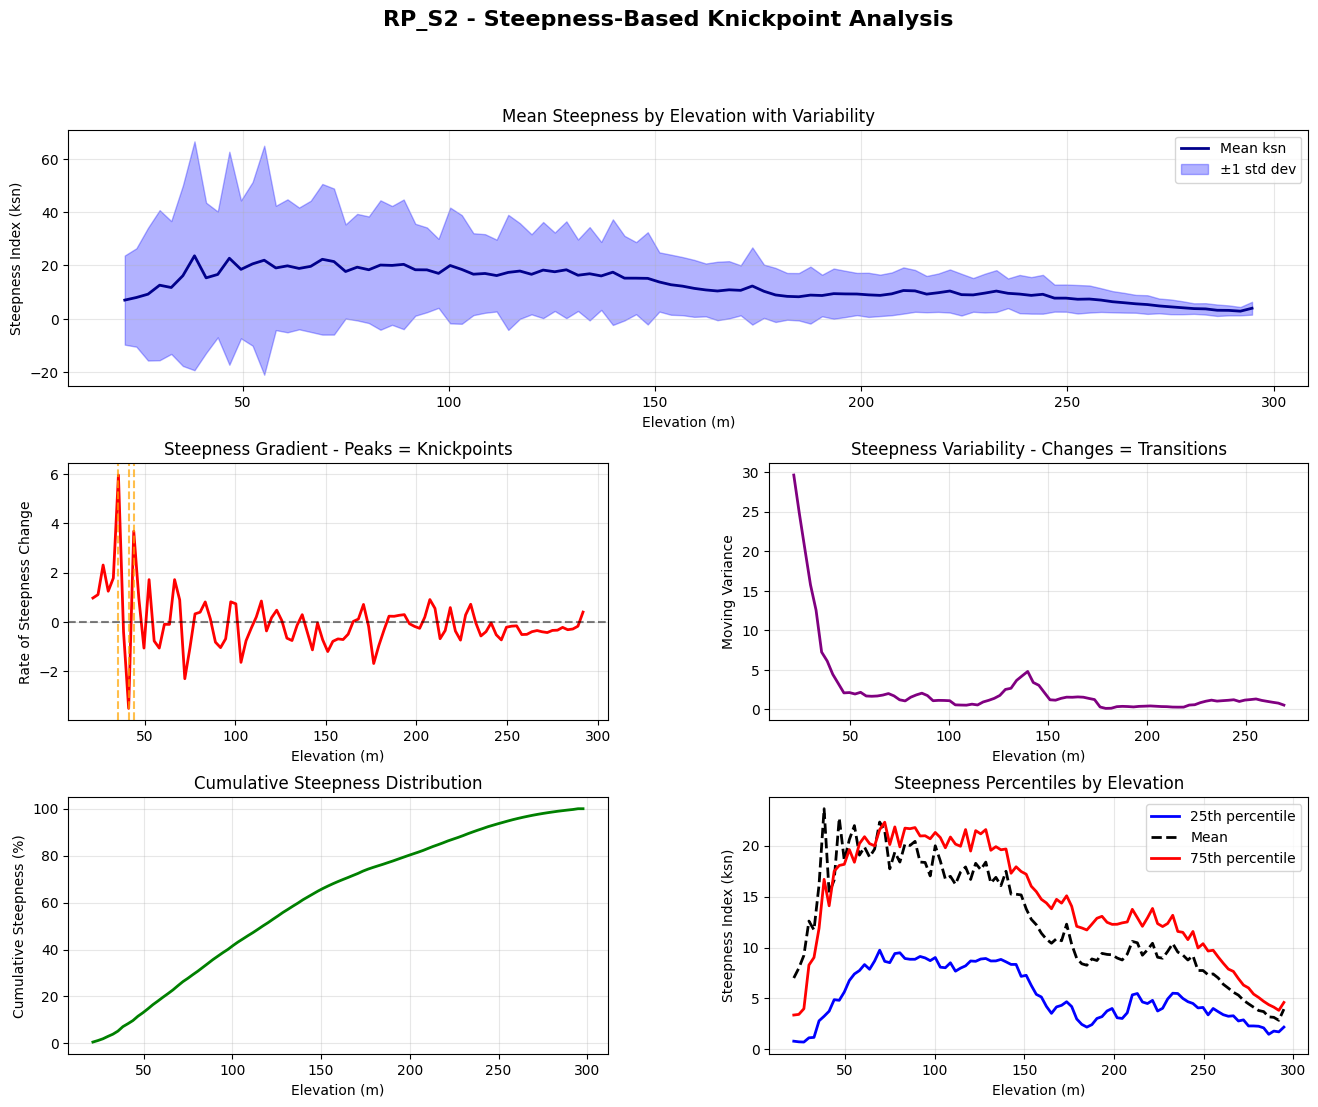


=== RP_S2 KNICKPOINT CANDIDATES (Steepness) ===
1. Elevation: 36m | Change: 5.952 ksn/m | Direction: flat→steep
2. Elevation: 44m | Change: 3.678 ksn/m | Direction: flat→steep
3. Elevation: 41m | Change: -3.497 ksn/m | Direction: steep→flat
4. Elevation: 27m | Change: 2.309 ksn/m | Direction: flat→steep
5. Elevation: 72m | Change: -2.295 ksn/m | Direction: steep→flat

Elevation range: 20m to 299m
Mean steepness: 12.77
Median steepness: 9.09
Max steepness: 484.99
Processing RP_S3...


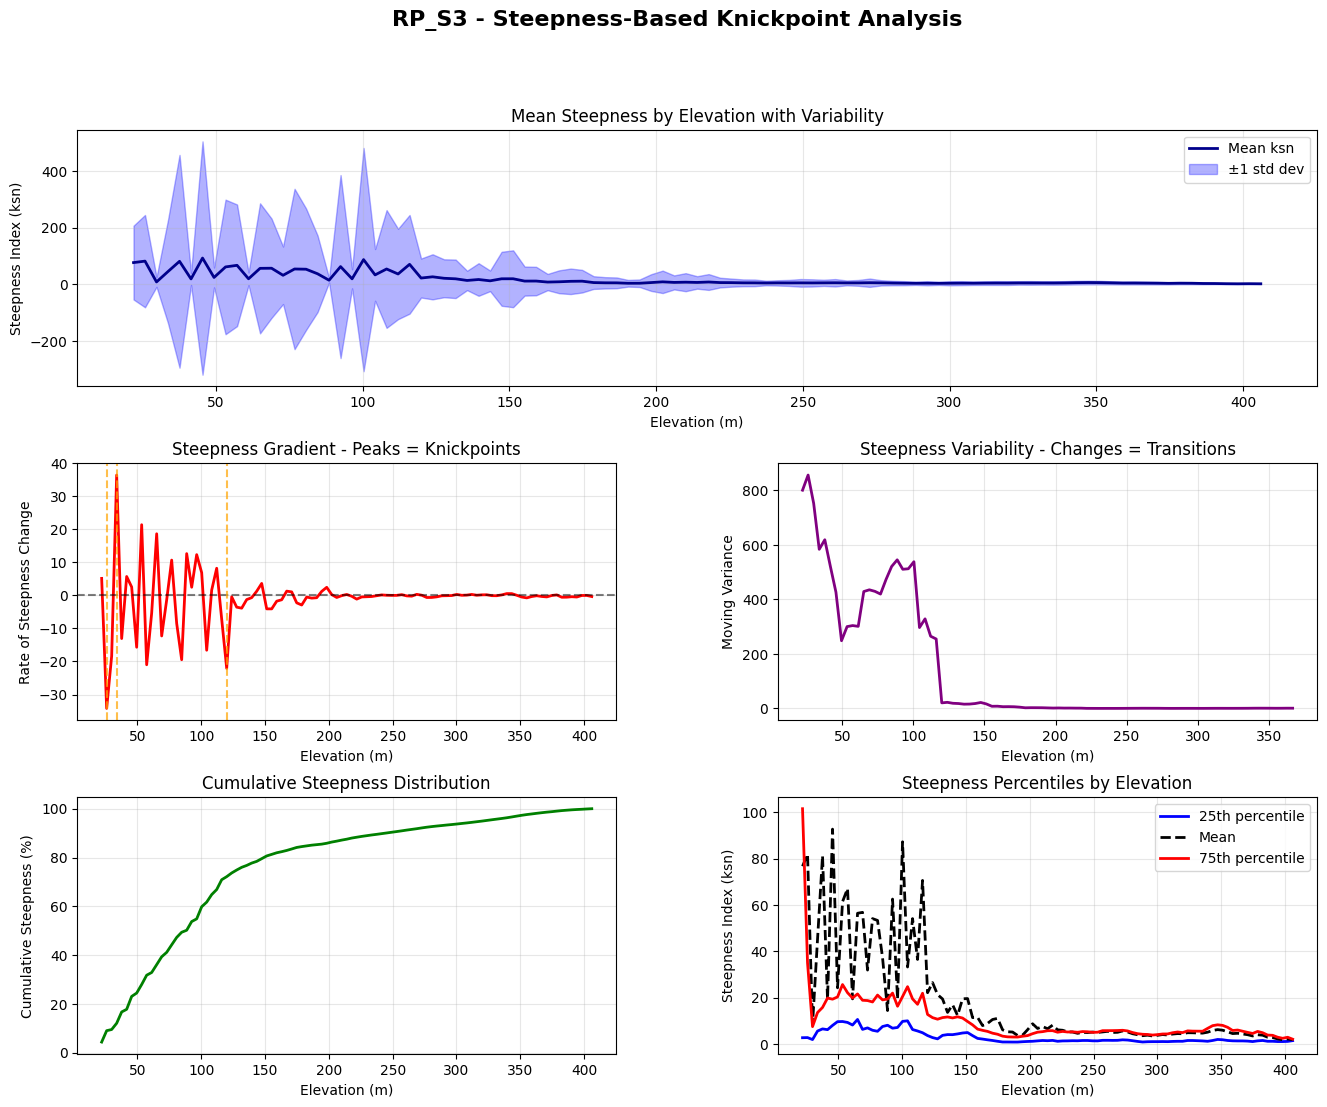


=== RP_S3 KNICKPOINT CANDIDATES (Steepness) ===
1. Elevation: 34m | Change: 36.476 ksn/m | Direction: flat→steep
2. Elevation: 26m | Change: -34.203 ksn/m | Direction: steep→flat
3. Elevation: 120m | Change: -22.069 ksn/m | Direction: steep→flat
4. Elevation: 53m | Change: 21.433 ksn/m | Direction: flat→steep
5. Elevation: 57m | Change: -20.986 ksn/m | Direction: steep→flat

Elevation range: 20m to 408m
Mean steepness: 5.29
Median steepness: 2.50
Max steepness: 2450.03
Processing RP_S3u...


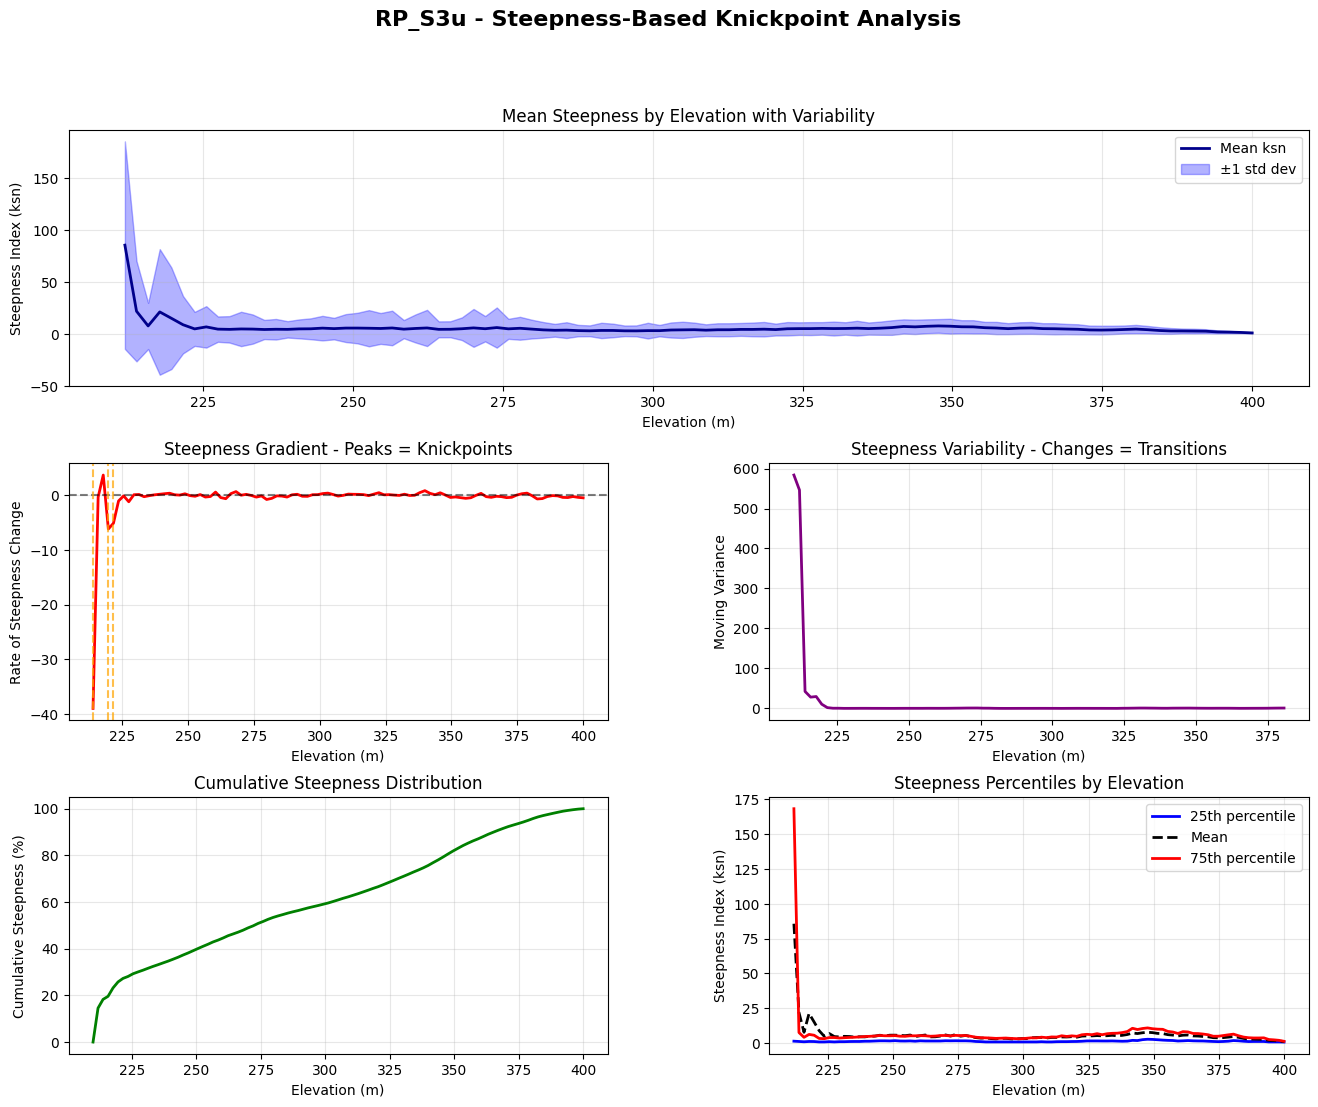


=== RP_S3u KNICKPOINT CANDIDATES (Steepness) ===
1. Elevation: 214m | Change: -38.966 ksn/m | Direction: steep→flat
2. Elevation: 220m | Change: -6.173 ksn/m | Direction: steep→flat
3. Elevation: 222m | Change: -5.119 ksn/m | Direction: steep→flat
4. Elevation: 218m | Change: 3.688 ksn/m | Direction: flat→steep
5. Elevation: 227m | Change: -1.194 ksn/m | Direction: steep→flat

Elevation range: 209m to 401m
Mean steepness: 4.70
Median steepness: 2.41
Max steepness: 542.11
Processing RP_S4u...


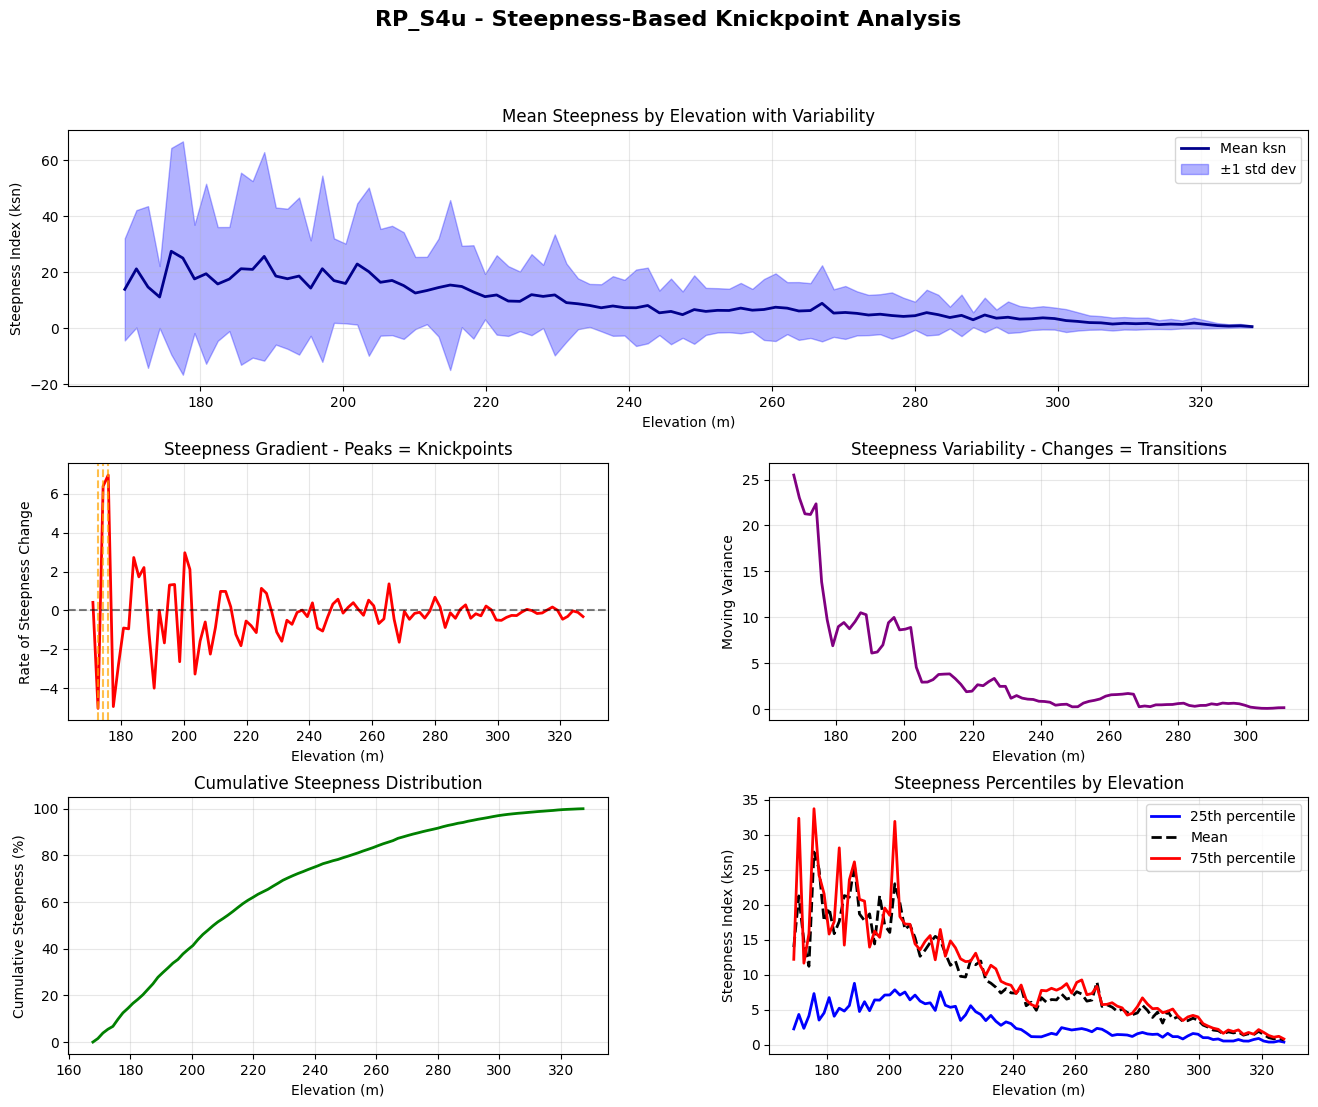


=== RP_S4u KNICKPOINT CANDIDATES (Steepness) ===
1. Elevation: 176m | Change: 6.954 ksn/m | Direction: flat→steep
2. Elevation: 174m | Change: 6.377 ksn/m | Direction: flat→steep
3. Elevation: 173m | Change: -5.029 ksn/m | Direction: steep→flat
4. Elevation: 178m | Change: -4.936 ksn/m | Direction: steep→flat
5. Elevation: 191m | Change: -3.991 ksn/m | Direction: steep→flat

Elevation range: 167m to 328m
Mean steepness: 6.57
Median steepness: 3.17
Max steepness: 224.19


In [11]:
import numpy as np
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import matplotlib.pyplot as plt

def steepness_knickpoint_analysis(shapefile_path, dem_path, area_path, title):
    """Comprehensive knickpoint analysis using steepness index (ksn)"""
    
    # Read shapefile
    shapefile = gpd.read_file(shapefile_path)
    
    # Clip DEM to shapefile
    print(f"Processing {title}...")
    with rasterio.open(dem_path) as dem_src:
        elevation, transform = mask(dem_src, shapefile.geometry, crop=True)
        elevation = elevation[0]
        nodata = dem_src.nodata
    
    # Clip drainage area to shapefile
    with rasterio.open(area_path) as area_src:
        drainage_area, _ = mask(area_src, shapefile.geometry, crop=True)
        drainage_area = drainage_area[0]
    
    # Clean elevation data
    elevation = elevation.astype(np.float32)
    if nodata is not None:
        elevation[elevation == nodata] = np.nan
    elevation[elevation == -32768] = np.nan
    
    # Calculate slope
    cell_size = transform[0]
    dy, dx = np.gradient(elevation, cell_size)
    slope_ratio = np.sqrt(dx**2 + dy**2)
    
    # Calculate steepness index (ksn)
    theta = 0.45
    steepness = slope_ratio * (drainage_area ** theta)
    
    # Filter valid values
    valid_mask = (~np.isnan(steepness) & 
                  ~np.isnan(elevation) & 
                  (elevation > 0) & 
                  (elevation < 10000) &
                  (drainage_area > 0))
    
    steepness_valid = steepness[valid_mask]
    elevation_valid = elevation[valid_mask]
    
    # Statistical analysis by elevation
    elevation_bins = np.linspace(elevation_valid.min(), elevation_valid.max(), 100)
    bin_centers = (elevation_bins[:-1] + elevation_bins[1:]) / 2
    mean_steepness = []
    std_steepness = []
    p25_steepness = []
    p75_steepness = []
    
    for i in range(len(elevation_bins) - 1):
        mask_bin = (elevation_valid >= elevation_bins[i]) & (elevation_valid < elevation_bins[i+1])
        if np.sum(mask_bin) > 10:
            mean_steepness.append(np.mean(steepness_valid[mask_bin]))
            std_steepness.append(np.std(steepness_valid[mask_bin]))
            p25_steepness.append(np.percentile(steepness_valid[mask_bin], 25))
            p75_steepness.append(np.percentile(steepness_valid[mask_bin], 75))
        else:
            mean_steepness.append(np.nan)
            std_steepness.append(np.nan)
            p25_steepness.append(np.nan)
            p75_steepness.append(np.nan)
    
    mean_steepness = np.array(mean_steepness)
    std_steepness = np.array(std_steepness)
    
    # Calculate rate of change (gradient of steepness with elevation)
    steepness_change = np.gradient(mean_steepness)
    
    # Moving window variance
    window_size = 10
    moving_variance = []
    for i in range(len(mean_steepness) - window_size):
        moving_variance.append(np.nanvar(mean_steepness[i:i+window_size]))
    
    # Create plots
    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)
    
    # Plot 1: Mean steepness with confidence bands
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(bin_centers, mean_steepness, linewidth=2, color='darkblue', label='Mean ksn')
    ax1.fill_between(bin_centers, 
                      mean_steepness - std_steepness, 
                      mean_steepness + std_steepness, 
                      alpha=0.3, color='blue', label='±1 std dev')
    ax1.set_xlabel('Elevation (m)')
    ax1.set_ylabel('Steepness Index (ksn)')
    ax1.set_title('Mean Steepness by Elevation with Variability')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Rate of change
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.plot(bin_centers, steepness_change, linewidth=2, color='red')
    ax2.axhline(0, color='black', linestyle='--', alpha=0.5)
    ax2.set_xlabel('Elevation (m)')
    ax2.set_ylabel('Rate of Steepness Change')
    ax2.set_title('Steepness Gradient - Peaks = Knickpoints')
    ax2.grid(True, alpha=0.3)
    
    # Mark top 3 candidates
    valid_indices = ~np.isnan(steepness_change)
    if np.sum(valid_indices) > 0:
        abs_changes = np.abs(steepness_change[valid_indices])
        top_3_indices = np.argsort(abs_changes)[-3:]
        valid_bin_centers = bin_centers[valid_indices]
        for idx in top_3_indices:
            ax2.axvline(valid_bin_centers[idx], color='orange', linestyle='--', alpha=0.7)
    
    # Plot 3: Moving variance
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.plot(bin_centers[:len(moving_variance)], moving_variance, linewidth=2, color='purple')
    ax3.set_xlabel('Elevation (m)')
    ax3.set_ylabel('Moving Variance')
    ax3.set_title('Steepness Variability - Changes = Transitions')
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Cumulative distribution
    ax4 = fig.add_subplot(gs[2, 0])
    cumsum_steepness = np.nancumsum(mean_steepness)
    cumsum_steepness = cumsum_steepness / cumsum_steepness[-1] * 100
    ax4.plot(bin_centers, cumsum_steepness, linewidth=2, color='green')
    ax4.set_xlabel('Elevation (m)')
    ax4.set_ylabel('Cumulative Steepness (%)')
    ax4.set_title('Cumulative Steepness Distribution')
    ax4.grid(True, alpha=0.3)
    
    # Plot 5: Percentile analysis
    ax5 = fig.add_subplot(gs[2, 1])
    ax5.plot(bin_centers, p25_steepness, linewidth=2, color='blue', label='25th percentile')
    ax5.plot(bin_centers, mean_steepness, linewidth=2, color='black', label='Mean', linestyle='--')
    ax5.plot(bin_centers, p75_steepness, linewidth=2, color='red', label='75th percentile')
    ax5.set_xlabel('Elevation (m)')
    ax5.set_ylabel('Steepness Index (ksn)')
    ax5.set_title('Steepness Percentiles by Elevation')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    plt.suptitle(f'{title} - Steepness-Based Knickpoint Analysis', fontsize=16, fontweight='bold')
    plt.show()
    
    # Print statistics
    print(f"\n{'='*50}")
    print(f"=== {title} KNICKPOINT CANDIDATES (Steepness) ===")
    print(f"{'='*50}")
    
    valid_indices = ~np.isnan(steepness_change)
    if np.sum(valid_indices) > 0:
        abs_changes = np.abs(steepness_change[valid_indices])
        top_5_indices = np.argsort(abs_changes)[-5:][::-1]
        valid_bin_centers = bin_centers[valid_indices]
        valid_steepness_change = steepness_change[valid_indices]
        
        for i, idx in enumerate(top_5_indices, 1):
            elev = valid_bin_centers[idx]
            change = valid_steepness_change[idx]
            direction = "steep→flat" if change < 0 else "flat→steep"
            print(f"{i}. Elevation: {elev:.0f}m | Change: {change:.3f} ksn/m | Direction: {direction}")
    
    print(f"\nElevation range: {elevation_valid.min():.0f}m to {elevation_valid.max():.0f}m")
    print(f"Mean steepness: {np.mean(steepness_valid):.2f}")
    print(f"Median steepness: {np.median(steepness_valid):.2f}")
    print(f"Max steepness: {np.max(steepness_valid):.2f}")


# File paths
dem_path = '/Users/Glong1/Desktop/Andes/Andes_watersheds/RapelRiver/rapel_SRTMGL130m_dem_utm.tif'
area_path = '/Users/Glong1/Desktop/Andes/Andes_watersheds/RapelRiver/rapel_area_utm30m'

# Run analysis for all 4 shapefiles
steepness_knickpoint_analysis(
    '/Users/Glong1/Desktop/Andes/AndesTG/Rapel/output_polygons/RP_S2_mask/RP_S2_mask.shp', 
    dem_path, area_path, 'RP_S2')

steepness_knickpoint_analysis(
    '/Users/Glong1/Desktop/Andes/AndesTG/Rapel/output_polygons/RP_S3_mask/RP_S3_mask.shp', 
    dem_path, area_path, 'RP_S3')

steepness_knickpoint_analysis(
    '/Users/Glong1/Desktop/Andes/AndesTG/Rapel/output_polygons/RP_S3u_mask/RP_S3u_mask.shp', 
    dem_path, area_path, 'RP_S3u')

steepness_knickpoint_analysis(
    '/Users/Glong1/Desktop/Andes/AndesTG/Rapel/output_polygons/RP_S4u_mask/RP_S4u_mask.shp', 
    dem_path, area_path, 'RP_S4u')


Testing knickpoints in Rapel River Basin - Full DEM
Total valid pixels: 132,789,965
Elevation range: 1m to 6573m

--- Testing Elevation: 175m ---

Steepness (ksn):
  Downstream (155-175m): median=2.30, mean=6.76, n=2,364,948
  Upstream (175-195m):   median=2.84, mean=7.43, n=2,151,180
  At knickpoint (±5m):       median=2.54, mean=7.08, n=1,239,192
  Ratio (upstream/downstream): 1.24x
  Jump: 0.54
  T-test p-value: 0.0000 ***SIGNIFICANT

Slope (degrees):
  Downstream: median=3.31°, mean=6.17°
  Upstream:   median=4.31°, mean=6.96°
  Ratio: 1.30x
  Jump: 1.00°
  T-test p-value: 0.0000 ***SIGNIFICANT

Max gradient location: 183m (value: 0.54)

--- Testing Elevation: 110m ---

Steepness (ksn):
  Downstream (90-110m): median=2.54, mean=9.53, n=1,463,098
  Upstream (110-130m):   median=2.45, mean=8.12, n=1,811,366
  At knickpoint (±5m):       median=2.45, mean=11.48, n=913,985
  Ratio (upstream/downstream): 0.97x
  Jump: -0.09
  T-test p-value: 0.0000 ***SIGNIFICANT

Slope (degrees):
  Dow

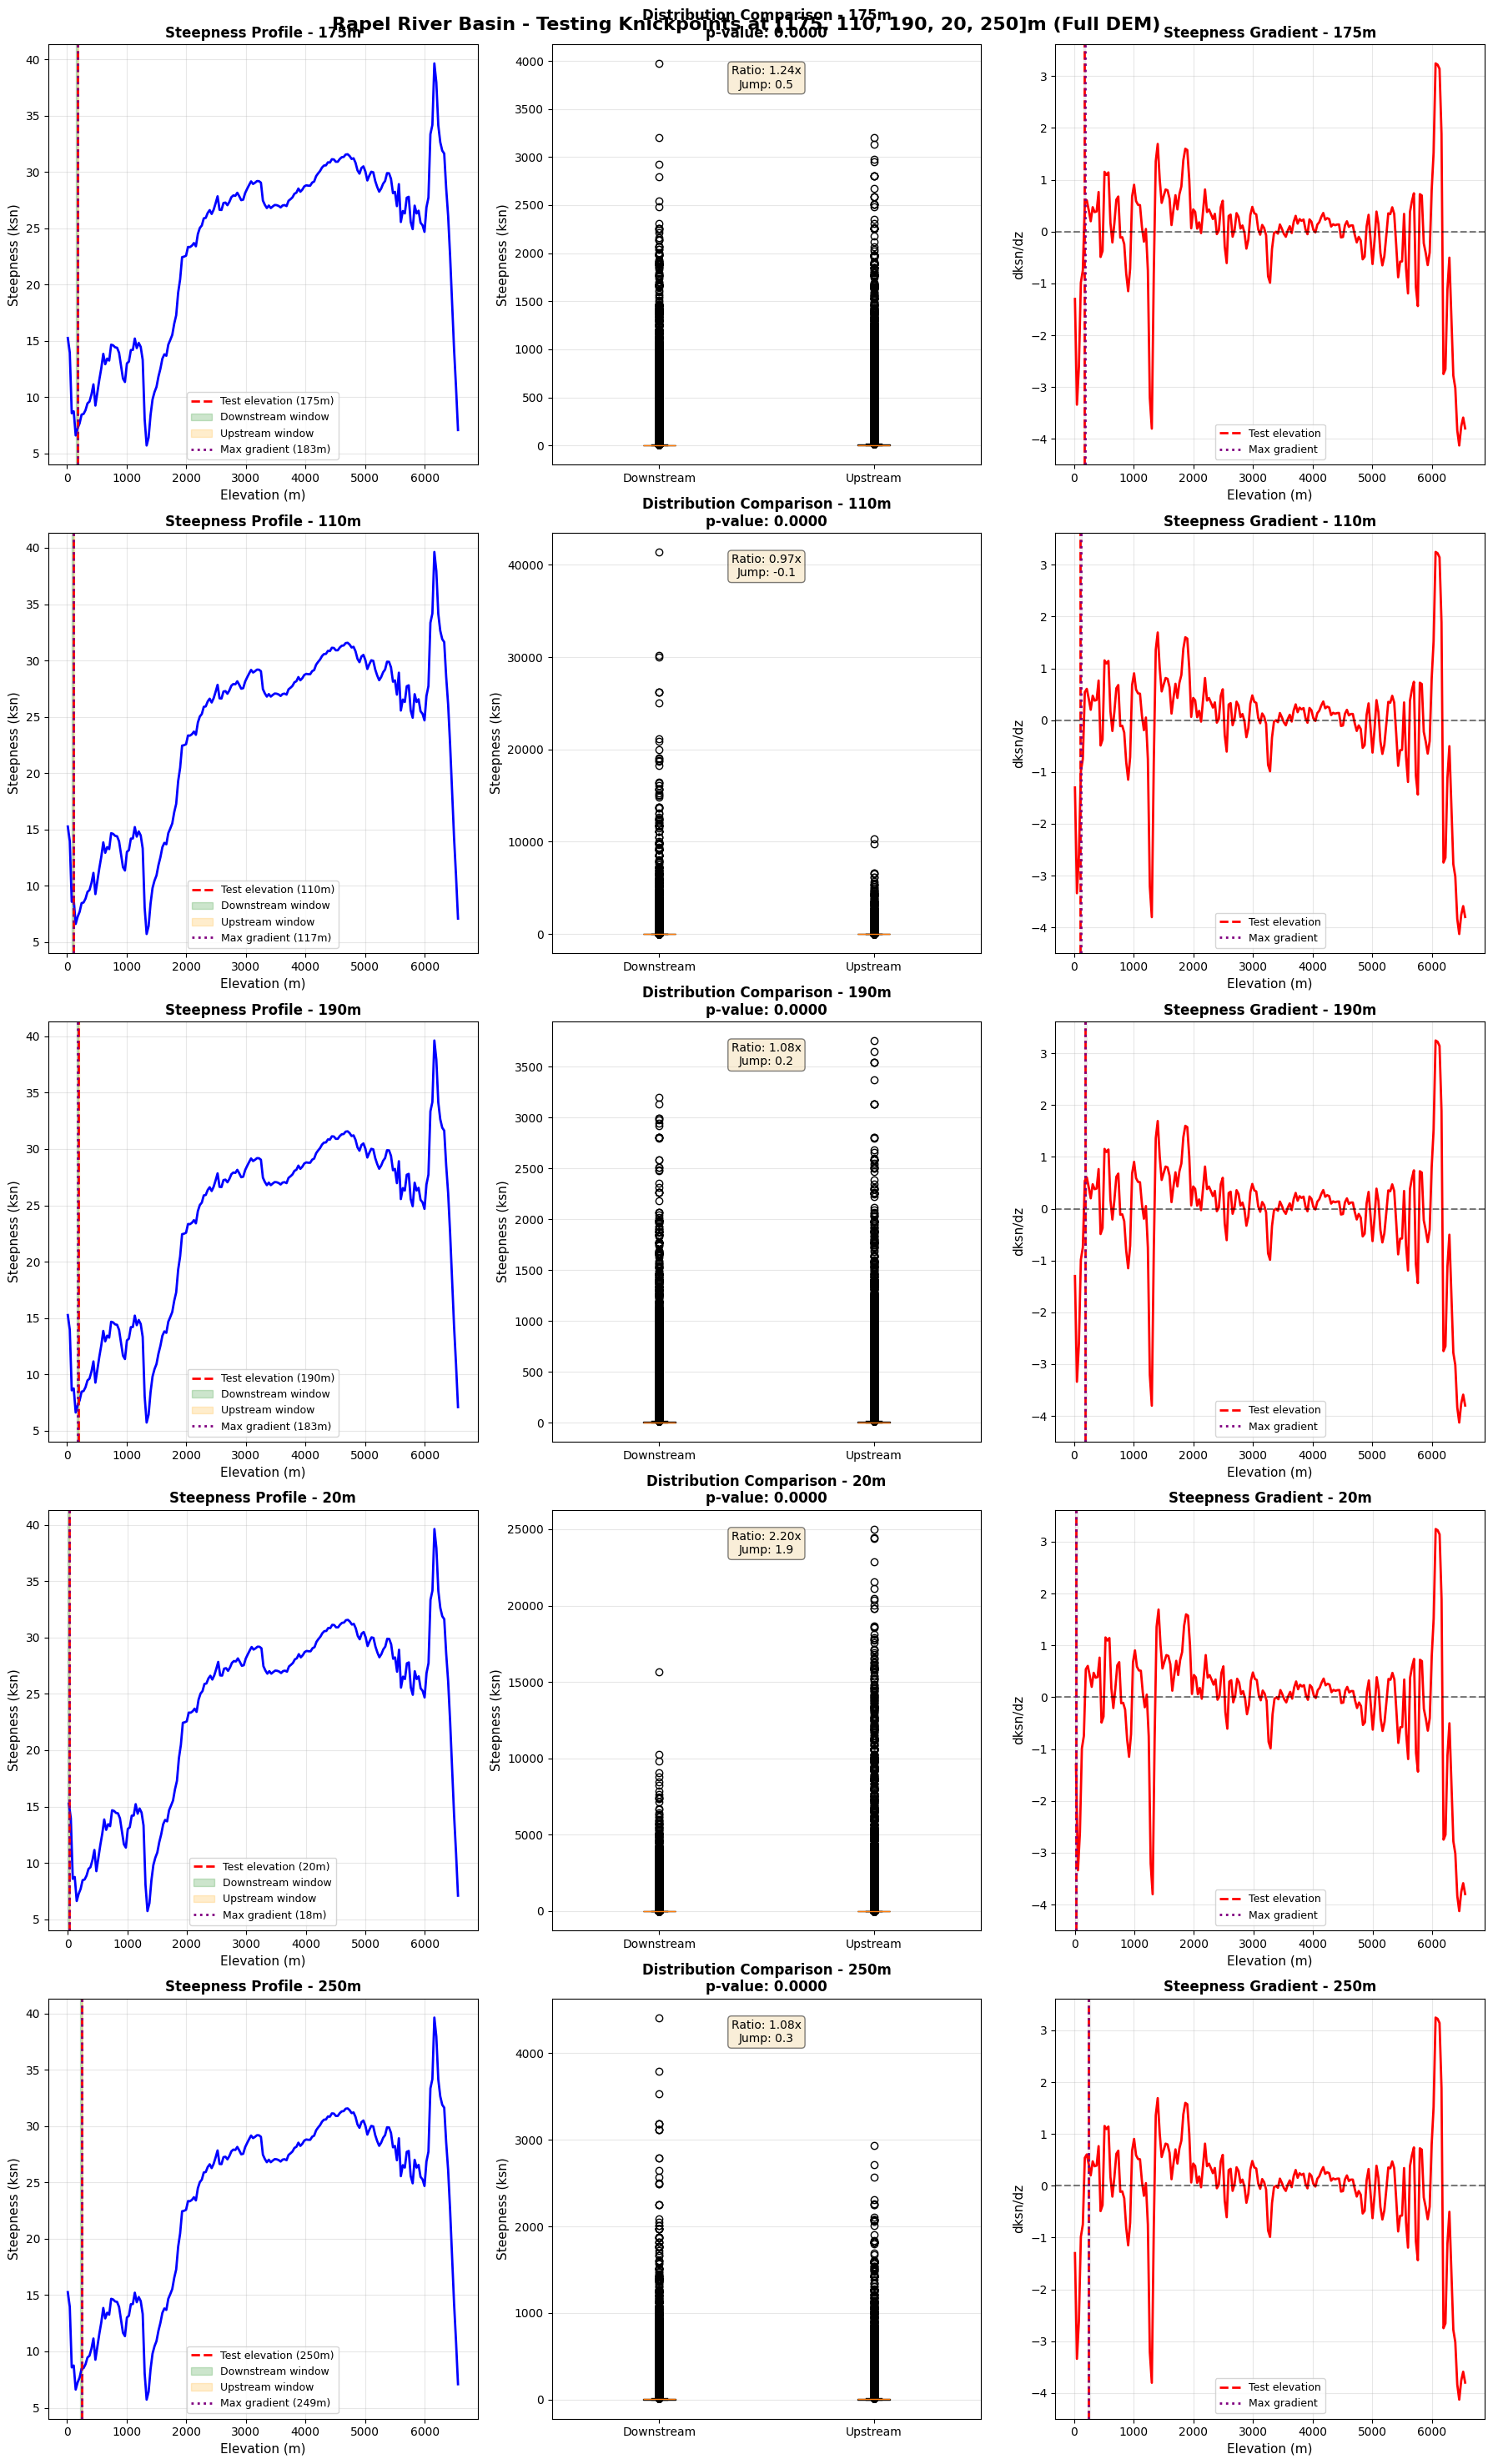


SUMMARY - Knickpoint Strength Assessment (Full DEM)
Elev(m)    ksn ratio    ksn jump     p-value      Assessment          
----------------------------------------------------------------------
175        1.24         0.54         0.0000       STRONG knickpoint   
110        0.97         -0.09        0.0000       STRONG knickpoint   
190        1.08         0.22         0.0000       STRONG knickpoint   
20         2.20         1.93         0.0000       STRONG knickpoint   
250        1.08         0.30         0.0000       STRONG knickpoint   


In [14]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from scipy import stats

def test_knickpoint_elevations_full_dem(dem_path, area_path, title, test_elevations, window=20):
    """
    Test specific elevations for knickpoint characteristics on full DEM
    
    Parameters:
    -----------
    test_elevations : list of floats
        Elevations to test (e.g., [175, 110])
    window : float
        Window size in meters above/below test elevation to analyze
    """
    
    # Read full DEM and drainage area
    print(f"\n{'='*70}")
    print(f"Testing knickpoints in {title} - Full DEM")
    print(f"{'='*70}")
    
    with rasterio.open(dem_path) as dem_src:
        elevation = dem_src.read(1).astype(np.float32)
        transform = dem_src.transform
        nodata = dem_src.nodata
    
    with rasterio.open(area_path) as area_src:
        drainage_area = area_src.read(1)
    
    # Clean data
    if nodata is not None:
        elevation[elevation == nodata] = np.nan
    elevation[elevation == -32768] = np.nan
    
    # Calculate steepness
    cell_size = transform[0]
    dy, dx = np.gradient(elevation, cell_size)
    slope_ratio = np.sqrt(dx**2 + dy**2)
    slope_degrees = np.degrees(np.arctan(slope_ratio))
    theta = 0.45
    steepness = slope_ratio * (drainage_area ** theta)
    
    # Filter valid values
    valid_mask = (~np.isnan(steepness) & ~np.isnan(elevation) & 
                  (elevation > 0) & (drainage_area > 0))
    steepness_valid = steepness[valid_mask]
    elevation_valid = elevation[valid_mask]
    slope_valid = slope_degrees[valid_mask]
    
    print(f"Total valid pixels: {np.sum(valid_mask):,}")
    print(f"Elevation range: {elevation_valid.min():.0f}m to {elevation_valid.max():.0f}m")
    
    # Create fine elevation bins for detailed analysis
    elevation_bins = np.linspace(elevation_valid.min(), elevation_valid.max(), 200)
    bin_centers = (elevation_bins[:-1] + elevation_bins[1:]) / 2
    mean_ksn = []
    mean_slope = []
    count = []
    
    for i in range(len(elevation_bins) - 1):
        mask_bin = (elevation_valid >= elevation_bins[i]) & (elevation_valid < elevation_bins[i+1])
        if np.sum(mask_bin) > 5:
            mean_ksn.append(np.mean(steepness_valid[mask_bin]))
            mean_slope.append(np.mean(slope_valid[mask_bin]))
            count.append(np.sum(mask_bin))
        else:
            mean_ksn.append(np.nan)
            mean_slope.append(np.nan)
            count.append(0)
    
    mean_ksn = np.array(mean_ksn)
    mean_slope = np.array(mean_slope)
    count = np.array(count)
    
    # Calculate derivative
    gradient_ksn = np.gradient(mean_ksn)
    gradient_slope = np.gradient(mean_slope)
    
    # Analyze each test elevation
    fig, axes = plt.subplots(len(test_elevations), 3, figsize=(18, 6*len(test_elevations)))
    if len(test_elevations) == 1:
        axes = axes.reshape(1, -1)
    
    results = []
    
    for idx, test_elev in enumerate(test_elevations):
        print(f"\n--- Testing Elevation: {test_elev}m ---")
        
        # Define upstream and downstream windows
        downstream_mask = (elevation_valid >= test_elev - window) & (elevation_valid < test_elev)
        upstream_mask = (elevation_valid > test_elev) & (elevation_valid <= test_elev + window)
        at_knickpoint_mask = (elevation_valid >= test_elev - 5) & (elevation_valid <= test_elev + 5)
        
        # Extract statistics for each zone
        if np.sum(downstream_mask) > 10 and np.sum(upstream_mask) > 10:
            # Steepness stats
            ksn_downstream = steepness_valid[downstream_mask]
            ksn_upstream = steepness_valid[upstream_mask]
            ksn_at_kp = steepness_valid[at_knickpoint_mask]
            
            # Slope stats
            slope_downstream = slope_valid[downstream_mask]
            slope_upstream = slope_valid[upstream_mask]
            slope_at_kp = slope_valid[at_knickpoint_mask]
            
            # Statistical tests
            # 1. T-test: Are upstream and downstream significantly different?
            t_stat_ksn, p_value_ksn = stats.ttest_ind(ksn_upstream, ksn_downstream)
            t_stat_slope, p_value_slope = stats.ttest_ind(slope_upstream, slope_downstream)
            
            # 2. Calculate knickpoint metrics
            ksn_ratio = np.median(ksn_upstream) / np.median(ksn_downstream) if np.median(ksn_downstream) > 0 else np.nan
            slope_ratio = np.median(slope_upstream) / np.median(slope_downstream) if np.median(slope_downstream) > 0 else np.nan
            ksn_jump = np.median(ksn_upstream) - np.median(ksn_downstream)
            slope_jump = np.median(slope_upstream) - np.median(slope_downstream)
            
            # 3. Find maximum gradient near test elevation
            bin_window_mask = (bin_centers >= test_elev - window) & (bin_centers <= test_elev + window)
            if np.sum(bin_window_mask & ~np.isnan(gradient_ksn)) > 0:
                max_gradient_elev = bin_centers[bin_window_mask][np.nanargmax(np.abs(gradient_ksn[bin_window_mask]))]
                max_gradient_value = np.nanmax(np.abs(gradient_ksn[bin_window_mask]))
            else:
                max_gradient_elev = test_elev
                max_gradient_value = 0
            
            # Store results
            result = {
                'elevation': test_elev,
                'ksn_downstream': np.median(ksn_downstream),
                'ksn_upstream': np.median(ksn_upstream),
                'ksn_ratio': ksn_ratio,
                'ksn_jump': ksn_jump,
                'ksn_pvalue': p_value_ksn,
                'slope_downstream': np.median(slope_downstream),
                'slope_upstream': np.median(slope_upstream),
                'slope_ratio': slope_ratio,
                'slope_jump': slope_jump,
                'slope_pvalue': p_value_slope,
                'max_gradient_elev': max_gradient_elev,
                'max_gradient_value': max_gradient_value,
                'n_downstream': len(ksn_downstream),
                'n_upstream': len(ksn_upstream)
            }
            results.append(result)
            
            # Print statistics
            print(f"\nSteepness (ksn):")
            print(f"  Downstream ({test_elev-window:.0f}-{test_elev:.0f}m): median={np.median(ksn_downstream):.2f}, mean={np.mean(ksn_downstream):.2f}, n={len(ksn_downstream):,}")
            print(f"  Upstream ({test_elev:.0f}-{test_elev+window:.0f}m):   median={np.median(ksn_upstream):.2f}, mean={np.mean(ksn_upstream):.2f}, n={len(ksn_upstream):,}")
            print(f"  At knickpoint (±5m):       median={np.median(ksn_at_kp):.2f}, mean={np.mean(ksn_at_kp):.2f}, n={len(ksn_at_kp):,}")
            print(f"  Ratio (upstream/downstream): {ksn_ratio:.2f}x")
            print(f"  Jump: {ksn_jump:.2f}")
            print(f"  T-test p-value: {p_value_ksn:.4f} {'***SIGNIFICANT' if p_value_ksn < 0.05 else '(not significant)'}")
            
            print(f"\nSlope (degrees):")
            print(f"  Downstream: median={np.median(slope_downstream):.2f}°, mean={np.mean(slope_downstream):.2f}°")
            print(f"  Upstream:   median={np.median(slope_upstream):.2f}°, mean={np.mean(slope_upstream):.2f}°")
            print(f"  Ratio: {slope_ratio:.2f}x")
            print(f"  Jump: {slope_jump:.2f}°")
            print(f"  T-test p-value: {p_value_slope:.4f} {'***SIGNIFICANT' if p_value_slope < 0.05 else '(not significant)'}")
            
            print(f"\nMax gradient location: {max_gradient_elev:.0f}m (value: {max_gradient_value:.2f})")
            
            # PLOT 1: Steepness profile with zones
            ax1 = axes[idx, 0]
            ax1.plot(bin_centers, mean_ksn, linewidth=2, color='blue')
            ax1.axvline(test_elev, color='red', linestyle='--', linewidth=2, label=f'Test elevation ({test_elev}m)')
            ax1.axvspan(test_elev - window, test_elev, alpha=0.2, color='green', label='Downstream window')
            ax1.axvspan(test_elev, test_elev + window, alpha=0.2, color='orange', label='Upstream window')
            ax1.axvline(max_gradient_elev, color='purple', linestyle=':', linewidth=2, label=f'Max gradient ({max_gradient_elev:.0f}m)')
            ax1.set_xlabel('Elevation (m)', fontsize=11)
            ax1.set_ylabel('Steepness (ksn)', fontsize=11)
            ax1.set_title(f'Steepness Profile - {test_elev}m', fontsize=12, fontweight='bold')
            ax1.legend(fontsize=9)
            ax1.grid(True, alpha=0.3)
            
            # PLOT 2: Box plots comparing distributions
            ax2 = axes[idx, 1]
            bp = ax2.boxplot([ksn_downstream, ksn_upstream], 
                             labels=['Downstream', 'Upstream'],
                             patch_artist=True)
            bp['boxes'][0].set_facecolor('green')
            bp['boxes'][1].set_facecolor('orange')
            ax2.set_ylabel('Steepness (ksn)', fontsize=11)
            ax2.set_title(f'Distribution Comparison - {test_elev}m\np-value: {p_value_ksn:.4f}', 
                         fontsize=12, fontweight='bold')
            ax2.grid(True, alpha=0.3, axis='y')
            
            # Add ratio annotation
            ax2.text(0.5, 0.95, f'Ratio: {ksn_ratio:.2f}x\nJump: {ksn_jump:.1f}',
                    transform=ax2.transAxes, fontsize=10,
                    verticalalignment='top', horizontalalignment='center',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
            
            # PLOT 3: Gradient (rate of change)
            ax3 = axes[idx, 2]
            ax3.plot(bin_centers, gradient_ksn, linewidth=2, color='red')
            ax3.axhline(0, color='black', linestyle='--', alpha=0.5)
            ax3.axvline(test_elev, color='red', linestyle='--', linewidth=2, label=f'Test elevation')
            ax3.axvspan(test_elev - window, test_elev + window, alpha=0.1, color='gray')
            ax3.axvline(max_gradient_elev, color='purple', linestyle=':', linewidth=2, label='Max gradient')
            ax3.set_xlabel('Elevation (m)', fontsize=11)
            ax3.set_ylabel('dksn/dz', fontsize=11)
            ax3.set_title(f'Steepness Gradient - {test_elev}m', fontsize=12, fontweight='bold')
            ax3.legend(fontsize=9)
            ax3.grid(True, alpha=0.3)
            
        else:
            print(f"  WARNING: Not enough data in upstream/downstream windows")
            for ax in axes[idx]:
                ax.text(0.5, 0.5, 'Insufficient data', ha='center', va='center', fontsize=14)
    
    plt.suptitle(f'{title} - Testing Knickpoints at {test_elevations}m (Full DEM)', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Summary table
    if results:
        print(f"\n{'='*70}")
        print(f"SUMMARY - Knickpoint Strength Assessment (Full DEM)")
        print(f"{'='*70}")
        print(f"{'Elev(m)':<10} {'ksn ratio':<12} {'ksn jump':<12} {'p-value':<12} {'Assessment':<20}")
        print(f"{'-'*70}")
        for r in results:
            if r['ksn_pvalue'] < 0.001:
                assessment = "STRONG knickpoint"
            elif r['ksn_pvalue'] < 0.05:
                assessment = "Significant knickpoint"
            elif r['ksn_ratio'] > 1.5:
                assessment = "Moderate (trend only)"
            else:
                assessment = "Weak/no knickpoint"
            
            print(f"{r['elevation']:<10.0f} {r['ksn_ratio']:<12.2f} {r['ksn_jump']:<12.2f} {r['ksn_pvalue']:<12.4f} {assessment:<20}")


# File paths
dem_path = '/Users/Glong1/Desktop/Andes/Andes_watersheds/RapelRiver/rapel_SRTMGL130m_dem_utm.tif'
area_path = '/Users/Glong1/Desktop/Andes/Andes_watersheds/RapelRiver/rapel_area_utm30m'

# Test full DEM at suspected knickpoint elevations
test_knickpoint_elevations_full_dem(
    dem_path, area_path, 'Rapel River Basin', 
    test_elevations=[175, 110, 190, 20, 250],  # Your suspected knickpoint elevations
    window=20)  # Analyze ±20m around each elevation


KNICKPOINT ANALYSIS

ksn Gradient Statistics:
  Mean gradient: 0.000165
  Median gradient: 0.000111
  95th percentile: 0.000517
  99th percentile: 0.000781

Potential knickpoint zones:
  Threshold: 0.000517
  Cells above threshold: 13310 (5.0%)
  Area: 9.96 km²

Knickpoint analysis saved to: rapel_knickpoint_analysis.png


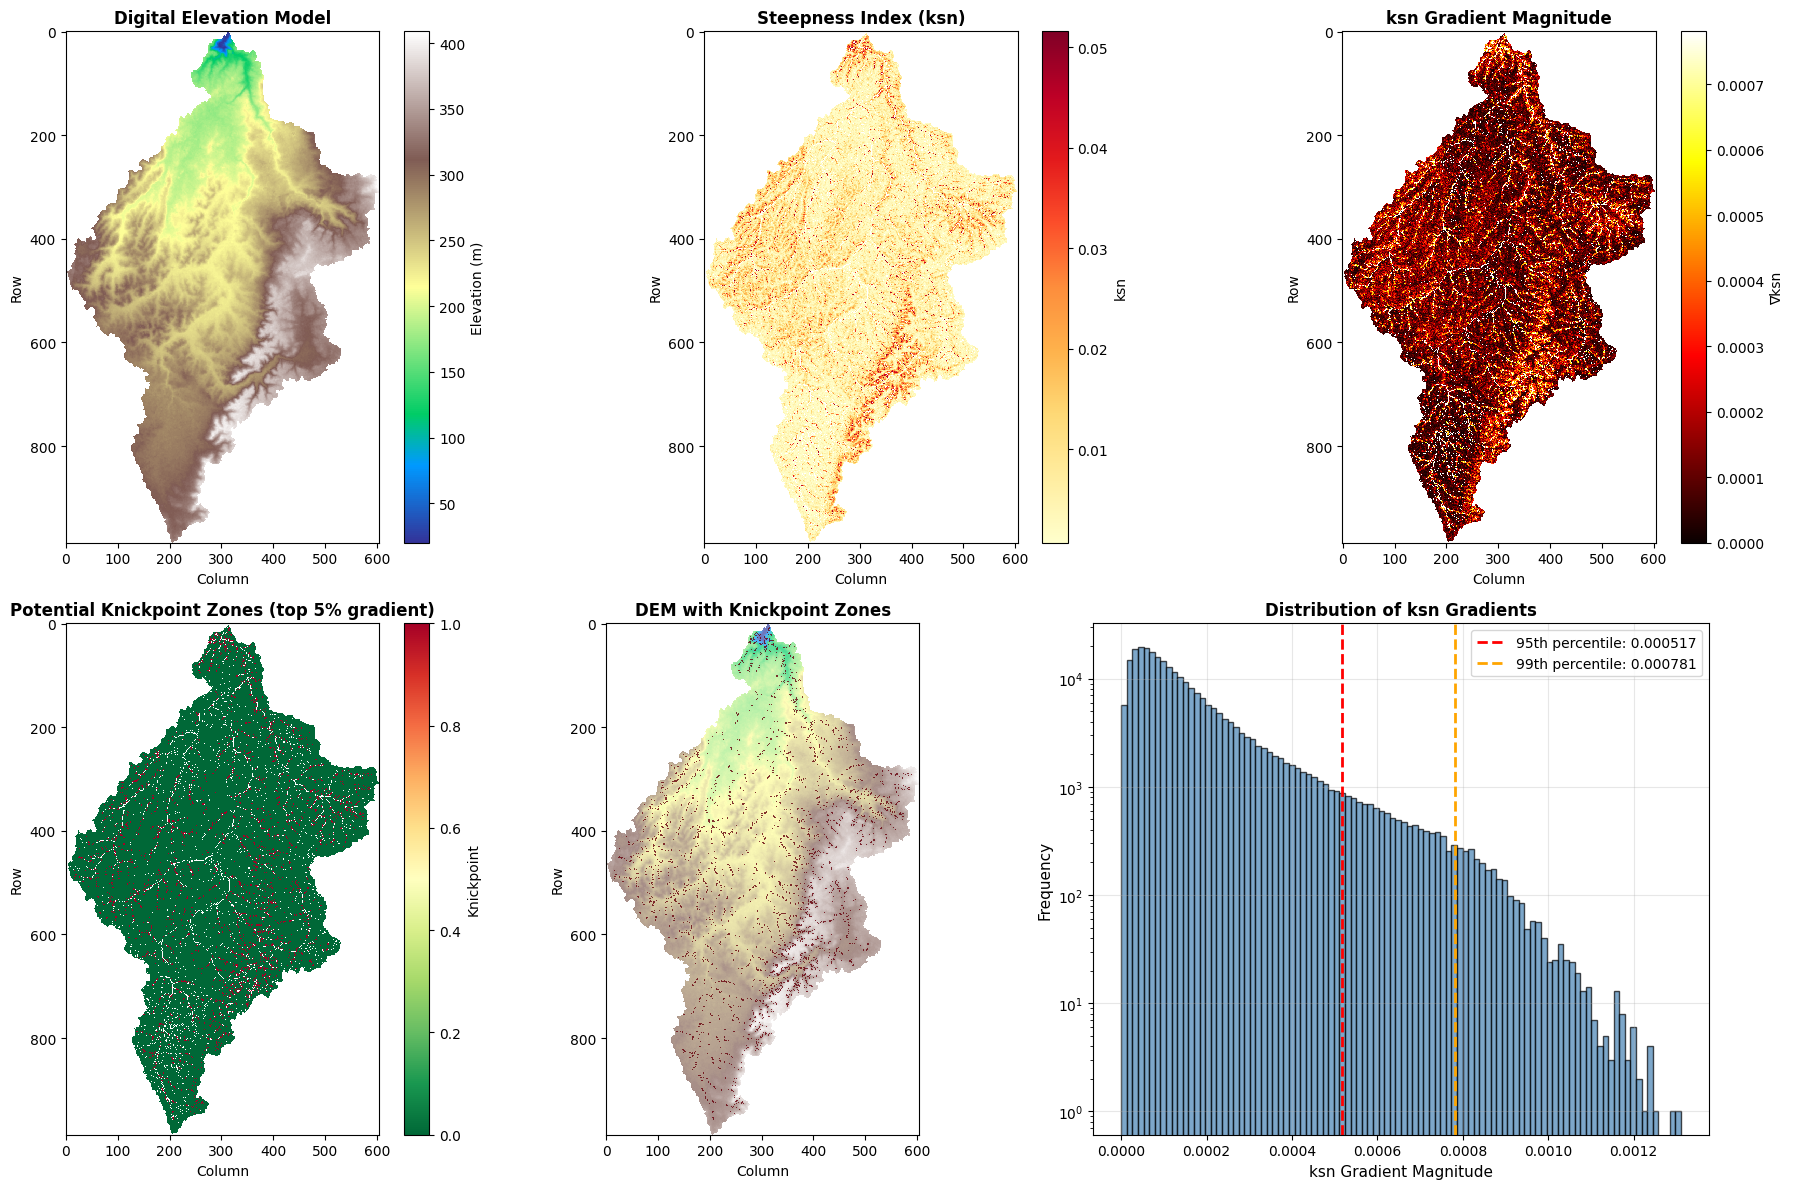

Knickpoint locations saved to: rapel_knickpoint_locations.csv

Top 10 highest gradient locations:
                   x             y  elevation       ksn  ksn_gradient
1264   252403.858749  6.232393e+06      201.0  0.002270      0.001310
160    250243.164016  6.237070e+06       61.0  0.041719      0.001295
12912  247344.003994  6.214999e+06      296.0  0.005129      0.001247
6900   249614.100992  6.224981e+06      223.0  0.001602      0.001241
12914  247316.653428  6.214971e+06      298.0  0.002266      0.001240
10833  251282.485533  6.219894e+06      335.0  0.023821      0.001237
4153   255767.978398  6.228072e+06      256.0  0.003916      0.001235
6870   249641.451559  6.225009e+06      221.0  0.002350      0.001220
10338  245867.073417  6.220441e+06      274.0  0.001602      0.001217
10745  251610.692328  6.220004e+06      317.0  0.019572      0.001211

Knickpoint analysis complete!


In [27]:
# =======================
# KNICKPOINT DETECTION
# =======================

print("\n" + "="*50)
print("KNICKPOINT ANALYSIS")
print("="*50)

# Calculate spatial gradients in ksn
ksn_for_gradient = ksn_array.copy()
ksn_for_gradient[np.isnan(ksn_for_gradient)] = 0  # Replace NaN with 0 for gradient calculation

# Calculate gradients
dksn_dy, dksn_dx = np.gradient(ksn_for_gradient, cellsize)
ksn_gradient_magnitude = np.sqrt(dksn_dx**2 + dksn_dy**2)

# Mask back to valid areas
ksn_gradient_magnitude[np.isnan(ksn_array)] = np.nan

# Calculate statistics
gradient_valid = ksn_gradient_magnitude[~np.isnan(ksn_gradient_magnitude)]
gradient_95th = np.nanpercentile(gradient_valid, 95)
gradient_99th = np.nanpercentile(gradient_valid, 99)

print(f"\nksn Gradient Statistics:")
print(f"  Mean gradient: {np.nanmean(gradient_valid):.6f}")
print(f"  Median gradient: {np.nanmedian(gradient_valid):.6f}")
print(f"  95th percentile: {gradient_95th:.6f}")
print(f"  99th percentile: {gradient_99th:.6f}")

# Define knickpoint threshold (using 95th percentile as high gradient zones)
knickpoint_threshold = gradient_95th
knickpoint_mask = ksn_gradient_magnitude > knickpoint_threshold
n_knickpoint_cells = np.sum(knickpoint_mask & ~np.isnan(ksn_gradient_magnitude))

print(f"\nPotential knickpoint zones:")
print(f"  Threshold: {knickpoint_threshold:.6f}")
print(f"  Cells above threshold: {n_knickpoint_cells} ({n_knickpoint_cells/len(gradient_valid)*100:.1f}%)")
print(f"  Area: {n_knickpoint_cells * cell_area / 1e6:.2f} km²")

# Also detect large jumps in ksn values
ksn_jump_threshold = 0.02  # Adjust this based on your data
ksn_jump_mask = np.abs(ksn_gradient_magnitude) > ksn_jump_threshold
n_jump_cells = np.sum(ksn_jump_mask & ~np.isnan(ksn_gradient_magnitude))

if n_jump_cells > 0:
    print(f"\nLarge ksn jumps (>{ksn_jump_threshold}):")
    print(f"  Number of cells: {n_jump_cells}")
    print(f"  These may indicate knickpoints, faults, or lithologic boundaries")

# Create knickpoint visualization
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. DEM
ax1 = axes[0, 0]
dem_plot = ax1.imshow(dem_array, cmap='terrain', interpolation='nearest')
ax1.set_title('Digital Elevation Model', fontsize=12, fontweight='bold')
ax1.set_xlabel('Column')
ax1.set_ylabel('Row')
plt.colorbar(dem_plot, ax=ax1, fraction=0.046, pad=0.04, label='Elevation (m)')

# 2. ksn map
ax2 = axes[0, 1]
ksn_plot = ax2.imshow(ksn_array, cmap='YlOrRd', interpolation='nearest')
ax2.set_title('Steepness Index (ksn)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Column')
ax2.set_ylabel('Row')
plt.colorbar(ksn_plot, ax=ax2, fraction=0.046, pad=0.04, label='ksn')

# 3. ksn gradient magnitude
ax3 = axes[0, 2]
gradient_plot = ax3.imshow(ksn_gradient_magnitude, cmap='hot', interpolation='nearest',
                           vmin=0, vmax=gradient_99th)
ax3.set_title('ksn Gradient Magnitude', fontsize=12, fontweight='bold')
ax3.set_xlabel('Column')
ax3.set_ylabel('Row')
plt.colorbar(gradient_plot, ax=ax3, fraction=0.046, pad=0.04, label='∇ksn')

# 4. Potential knickpoint zones
ax4 = axes[1, 0]
knickpoint_display = np.where(knickpoint_mask, 1, 0).astype(float)
knickpoint_display[np.isnan(ksn_array)] = np.nan
knick_plot = ax4.imshow(knickpoint_display, cmap='RdYlGn_r', interpolation='nearest',
                        vmin=0, vmax=1)
ax4.set_title(f'Potential Knickpoint Zones (top 5% gradient)', fontsize=12, fontweight='bold')
ax4.set_xlabel('Column')
ax4.set_ylabel('Row')
plt.colorbar(knick_plot, ax=ax4, fraction=0.046, pad=0.04, label='Knickpoint')

# 5. DEM with knickpoints overlaid
ax5 = axes[1, 1]
ax5.imshow(dem_array, cmap='terrain', interpolation='nearest', alpha=0.7)
knickpoint_overlay = np.ma.masked_where(~knickpoint_mask, knickpoint_display)
ax5.imshow(knickpoint_overlay, cmap='Reds', interpolation='nearest', alpha=0.8, vmin=0, vmax=1)
ax5.set_title('DEM with Knickpoint Zones', fontsize=12, fontweight='bold')
ax5.set_xlabel('Column')
ax5.set_ylabel('Row')

# 6. Histogram of ksn gradient
ax6 = axes[1, 2]
ax6.hist(gradient_valid, bins=100, edgecolor='black', alpha=0.7, color='steelblue')
ax6.axvline(gradient_95th, color='red', linestyle='--', linewidth=2, 
            label=f'95th percentile: {gradient_95th:.6f}')
ax6.axvline(gradient_99th, color='orange', linestyle='--', linewidth=2,
            label=f'99th percentile: {gradient_99th:.6f}')
ax6.set_xlabel('ksn Gradient Magnitude', fontsize=11)
ax6.set_ylabel('Frequency', fontsize=11)
ax6.set_title('Distribution of ksn Gradients', fontsize=12, fontweight='bold')
ax6.set_yscale('log')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('rapel_knickpoint_analysis.png', dpi=300, bbox_inches='tight')
print(f"\nKnickpoint analysis saved to: rapel_knickpoint_analysis.png")
plt.show()

# Export knickpoint locations
knickpoint_coords = np.where(knickpoint_mask & ~np.isnan(ksn_gradient_magnitude))
if len(knickpoint_coords[0]) > 0:
    # Convert to coordinates
    knickpoint_data = []
    for i, j in zip(knickpoint_coords[0], knickpoint_coords[1]):
        x, y = rasterio.transform.xy(dem_transform, i, j)
        knickpoint_data.append({
            'row': i,
            'col': j,
            'x': x,
            'y': y,
            'elevation': dem_array[i, j] if not np.isnan(dem_array[i, j]) else None,
            'ksn': ksn_array[i, j] if not np.isnan(ksn_array[i, j]) else None,
            'ksn_gradient': ksn_gradient_magnitude[i, j]
        })
    
    knickpoint_df = pd.DataFrame(knickpoint_data)
    knickpoint_df.to_csv('rapel_knickpoint_locations.csv', index=False)
    print(f"Knickpoint locations saved to: rapel_knickpoint_locations.csv")
    print(f"\nTop 10 highest gradient locations:")
    print(knickpoint_df.nlargest(10, 'ksn_gradient')[['x', 'y', 'elevation', 'ksn', 'ksn_gradient']])

print("\nKnickpoint analysis complete!")